In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_file = '/kaggle/input/who-is-the-real-winner/train.csv'
train_df = pd.read_csv(train_data_file)

In [3]:
def convert_to_numeric(value):
    if 'Crore' in value:
        return int(float(value.replace(' Crore+', '')) * 10000000)
    elif 'Lac' in value:
        return int(float(value.replace(' Lac+', '')) * 100000)
    elif 'Thou' in value:
        return int(float(value.replace(' Thou+', '')) * 1000)
    elif 'Hund' in value:
        return int(float(value.replace(' Hund+', '')) * 100)
    elif value == '0':
        return int(0)
    
train_df['Total Assets'] = train_df['Total Assets'].apply(convert_to_numeric)
train_df['Liabilities'] = train_df['Liabilities'].apply(convert_to_numeric)

In [4]:
region_mapping = {
    'South': ['TAMIL NADU', 'KARNATAKA', 'KERALA', 'ANDHRA PRADESH', 'PUDUCHERRY'],
    'North': ['UTTAR PRADESH', 'PUNJAB', 'HARYANA', 'DELHI', 'HIMACHAL PRADESH', 'RAJASTHAN', 'UTTARAKHAND'],
    'West': ['MAHARASHTRA', 'GUJARAT', 'GOA'],
    'East': ['WEST BENGAL', 'ODISHA', 'JHARKHAND', 'BIHAR'],
    'North East': ['MEGHALAYA', 'MANIPUR', 'NAGALAND', 'SIKKIM', 'TRIPURA', 'ASSAM', 'ARUNACHAL PRADESH'],
    'Central': ['MADHYA PRADESH', 'CHHATTISGARH']
}

# Create 'Regions' column based on 'State' column using region_mapping
train_df['Region'] = train_df['state'].map({state: region for region, states in region_mapping.items() \
                                            for state in states})

In [5]:
party_region_mapping = {
        'Regional Parties': ['AAP', 'JD(U)', 'SHS', 'TDP', 'AIADMK', 'DMK', 'JD(S)', 'YSRCP', 
                             'Sikkim Krantikari Morcha', 'Tipra Motha Party', 
                             'SP', 'AITC', 'BJD', 'CPI', 'CPI(M)', 'RJD', 
                             'NCP', 'NDPP', 'IND', 'JMM', 'NPP'],
        'Nationwide Parties': ['BJP', 'INC'],
    }
train_df['Party Region'] = train_df['Party'].map({party: region for region, Party in party_region_mapping.items() \
                                                  for party in Party})

In [6]:
def extract_reservation_category(con):
    if 'SC' in con.upper():
        return 'SC'
    elif 'ST' in con.upper():
        return 'ST'
    else:
        return 'General'

# Apply the function to create the Reservation Category column
train_df['Reservation Category'] = train_df['Constituency ∇'].apply(extract_reservation_category)

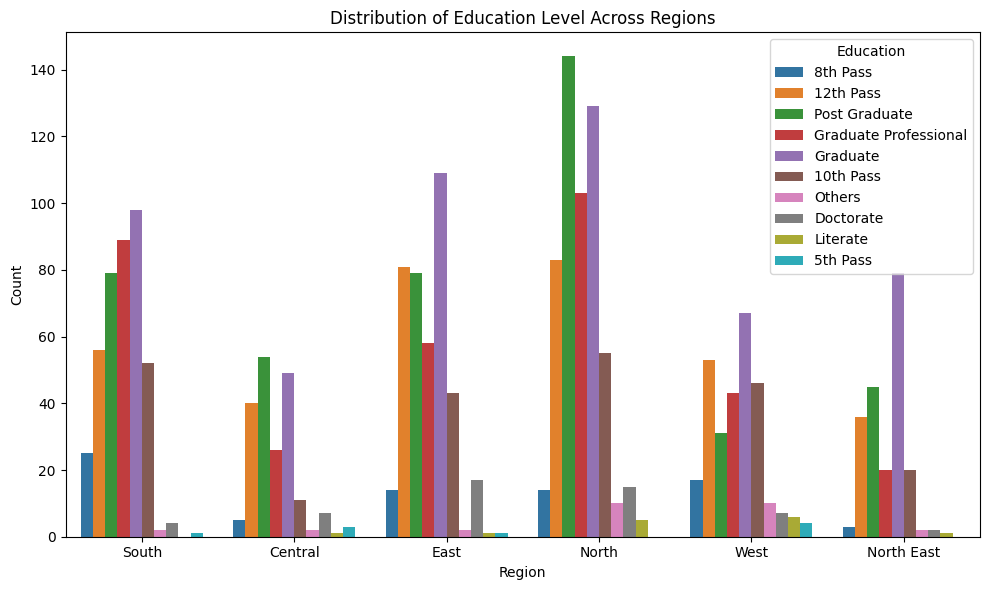

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Region', hue='Education', data=train_df)
plt.title('Distribution of Education Level Across Regions')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(title='Education')
plt.tight_layout()
plt.savefig('Education_vs_Region.png')
plt.show()

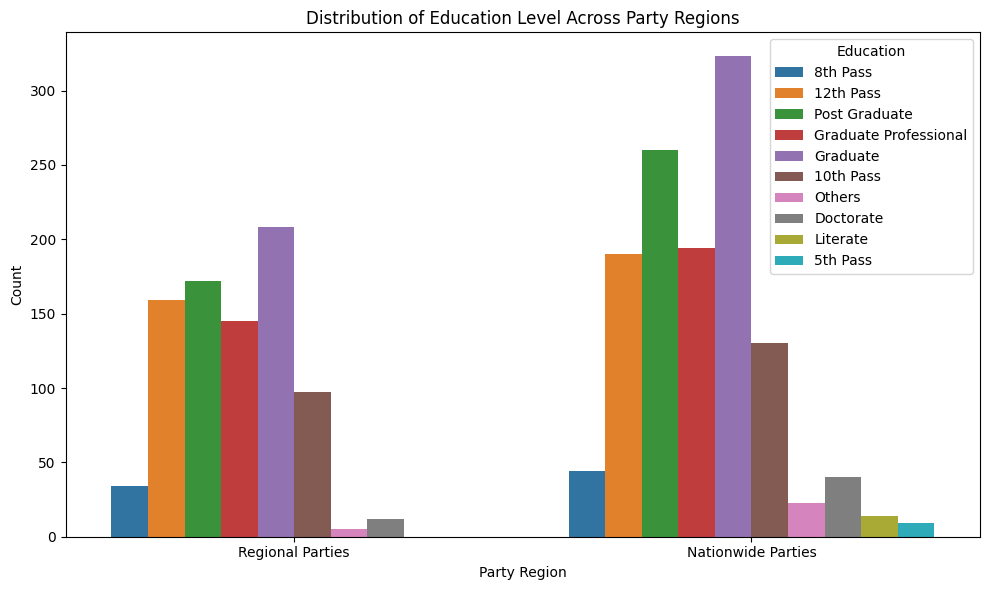

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Party Region', hue='Education', data=train_df)
plt.title('Distribution of Education Level Across Party Regions')
plt.xlabel('Party Region')
plt.ylabel('Count')
plt.legend(title='Education')
plt.tight_layout()
plt.savefig('Education_vs_Party_Region.png')
plt.show()

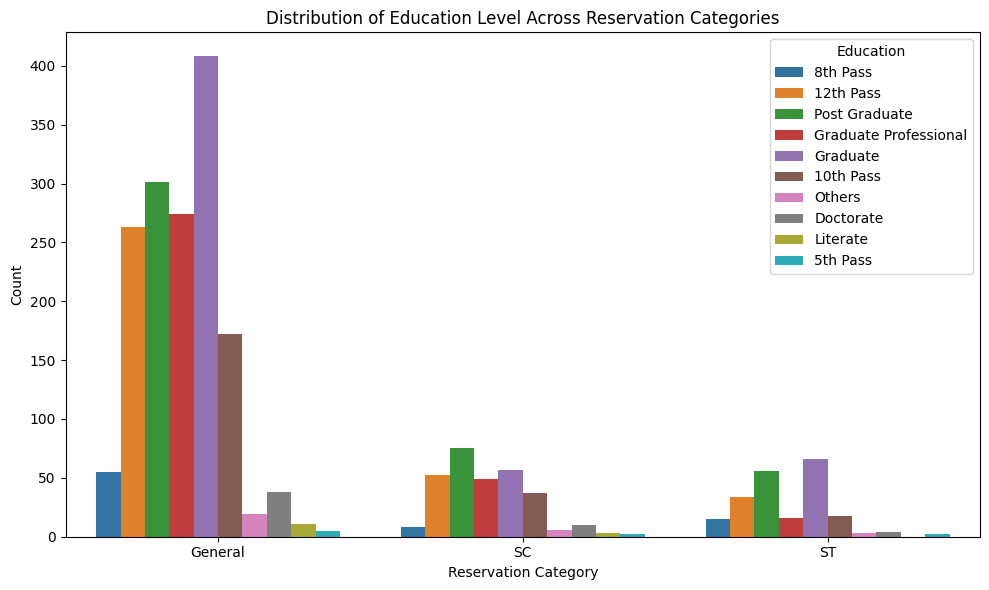

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Reservation Category', hue='Education', data=train_df)
plt.title('Distribution of Education Level Across Reservation Categories')
plt.xlabel('Reservation Category')
plt.ylabel('Count')
plt.legend(title='Education')
plt.tight_layout()
plt.savefig('Education_vs_Res_Category.png')
plt.show()

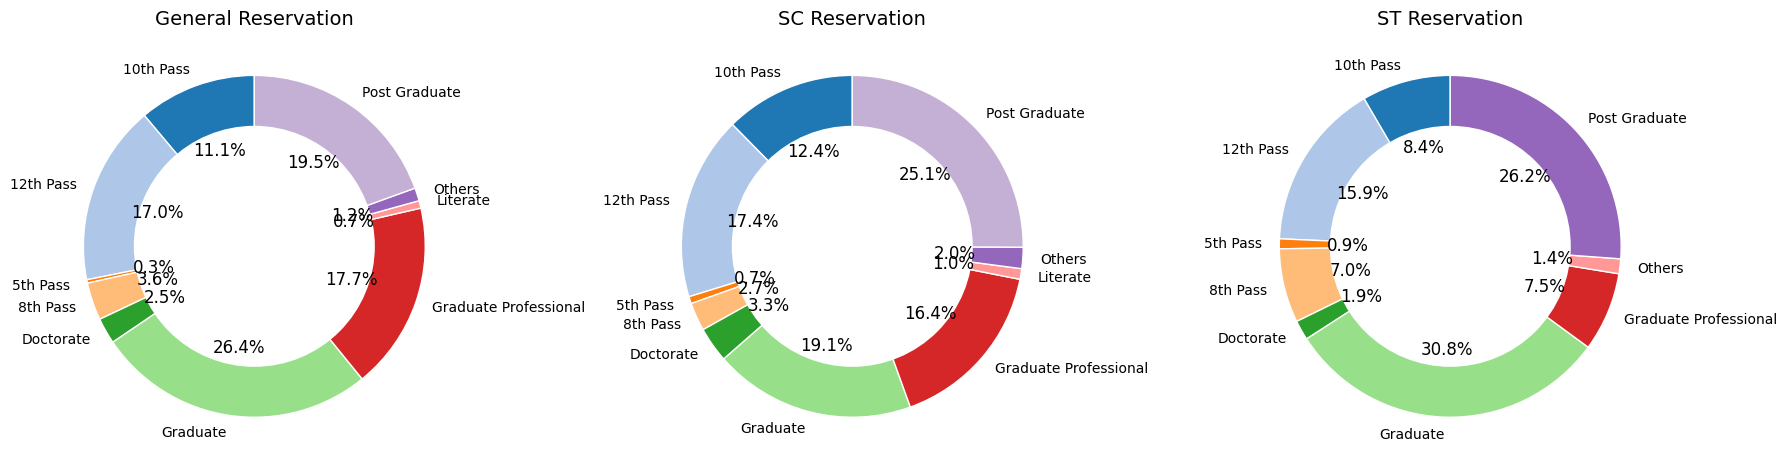

In [10]:
# Calculate percentage of each education level within each reservation category
education_percentages = train_df.groupby(['Reservation Category', 'Education']).size() / train_df.groupby('Reservation Category').size() * 100
education_percentages = education_percentages.reset_index(name='Percentage')

# Plotting the donut chart
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Iterate through each reservation category
for idx, (res_category, group_df) in enumerate(education_percentages.groupby('Reservation Category')):
    ax = axs[idx]
    ax.set_title(f'{res_category} Reservation', fontsize=14)
    
    # Create the donut chart
    wedges, texts, autotexts = ax.pie(group_df['Percentage'], labels=group_df['Education'], autopct='%1.1f%%',
                                      wedgeprops={'edgecolor': 'white'}, startangle=90, colors=plt.cm.tab20.colors)
    
    # Increase font size of percentages
    for autotext in autotexts:
        autotext.set_fontsize(12)
    
    # Draw circle to create donut chart
    centre_circle = plt.Circle((0, 0), 0.7, color='white', fc='white', linewidth=1.25)
    ax.add_artist(centre_circle)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('donut_chart_education_vs_res_category.png')
plt.show()

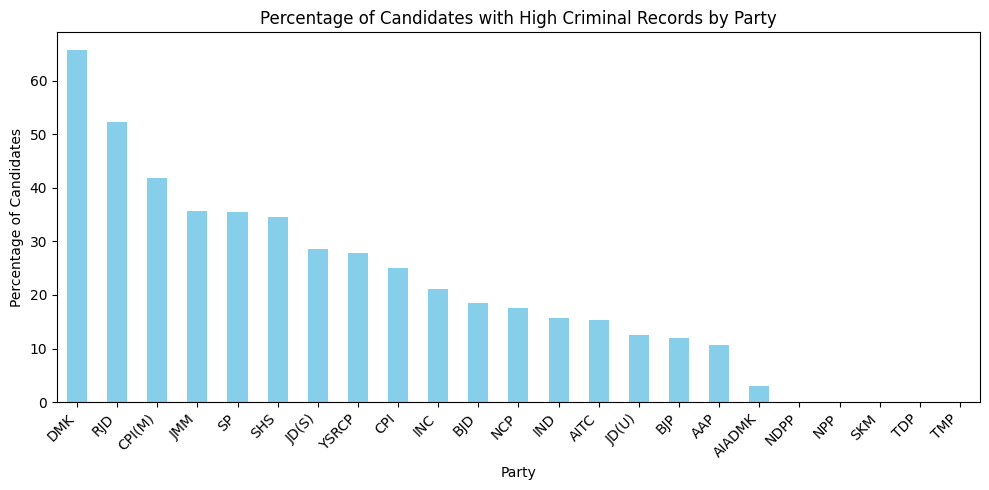

In [11]:
# Define the threshold for a high criminal record
high_criminal_threshold = 2

# Count the number of candidates with high criminal records for each party
high_criminal_cases = train_df[train_df['Criminal Case'] > high_criminal_threshold].groupby('Party').size()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate the percentage of candidates with high criminal records for each party
percentage_high_criminal = (high_criminal_cases / party_candidate_count) * 100

plt.figure(figsize=(10, 5))

percentage_high_criminal.rename(index={'Tipra Motha Party': 'TMP',
                                'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)
percentage_high_criminal.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Percentage of Candidates with High Criminal Records by Party')
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('poc_criminal_vs_party.png')
plt.show()

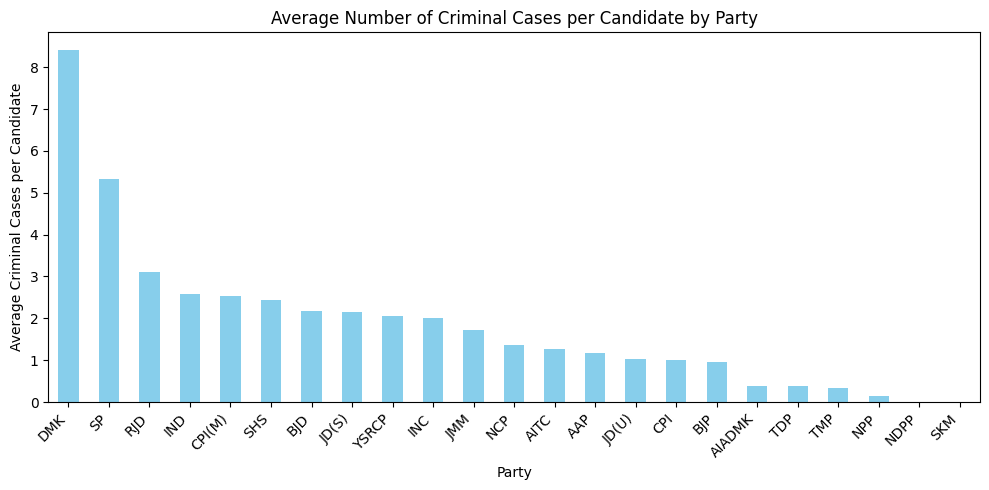

In [12]:
# Group by party and sum the criminal cases
party_criminal_cases = train_df.groupby('Party')['Criminal Case'].sum()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate average criminal cases per candidate for each party
avg_criminal_cases_per_candidate = party_criminal_cases / party_candidate_count


plt.figure(figsize=(10, 5))
avg_criminal_cases_per_candidate.rename(index={'Tipra Motha Party': 'TMP',
                                        'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)
avg_criminal_cases_per_candidate.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Average Number of Criminal Cases per Candidate by Party')
plt.xlabel('Party')
plt.ylabel('Average Criminal Cases per Candidate')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('avg_criminal_vs_party.png')
plt.show()

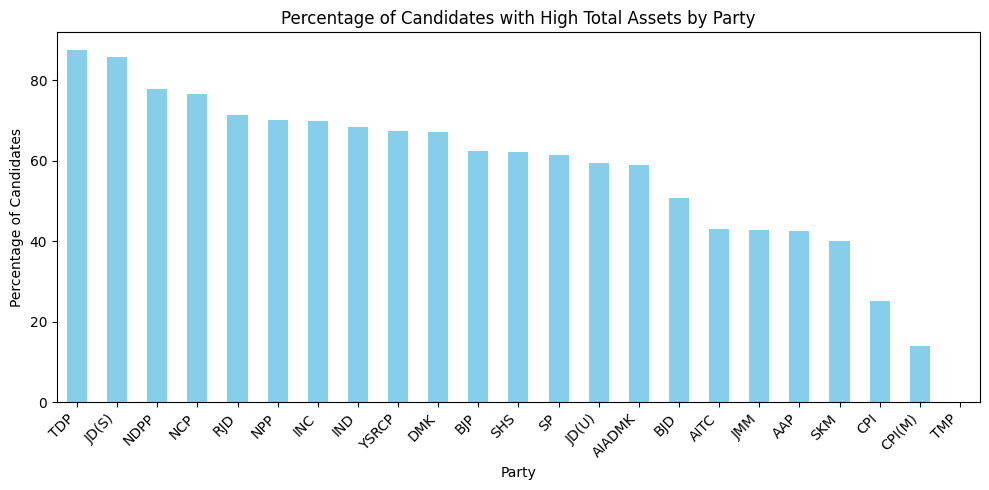

In [13]:
# Define the threshold for high total assets
high_assets_threshold = 10000000

# Count the number of candidates with high total assets for each party
high_assets_cases = train_df[train_df['Total Assets'] > high_assets_threshold].groupby('Party').size()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate the percentage of candidates with high total assets for each party
percentage_high_assets = (high_assets_cases / party_candidate_count) * 100
percentage_high_assets.rename(index={'Tipra Motha Party': 'TMP',
                                      'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)

plt.figure(figsize=(10, 5))
percentage_high_assets.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Percentage of Candidates with High Total Assets by Party')
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('poc_assets_vs_party.png')
plt.show()

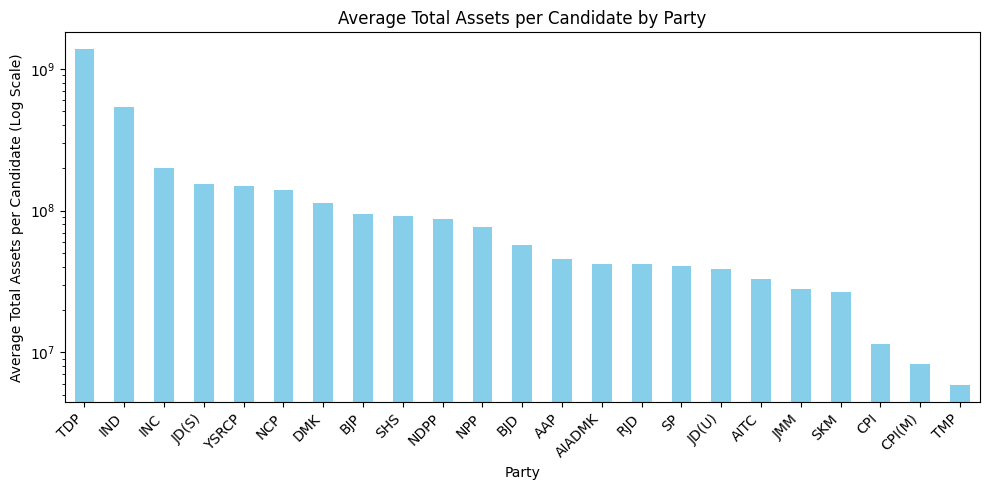

In [14]:
# Group by party and calculate the total assets
party_total_assets = train_df.groupby('Party')['Total Assets'].sum()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate average assets per candidate for each party
avg_assets_per_candidate = party_total_assets / party_candidate_count

plt.figure(figsize=(10, 5))
avg_assets_per_candidate.rename(index={'Tipra Motha Party': 'TMP',
                                'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)
avg_assets_per_candidate.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Average Total Assets per Candidate by Party')
plt.xlabel('Party')
plt.ylabel('Average Total Assets per Candidate (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.savefig('avg_assets_vs_party.png')
plt.show()

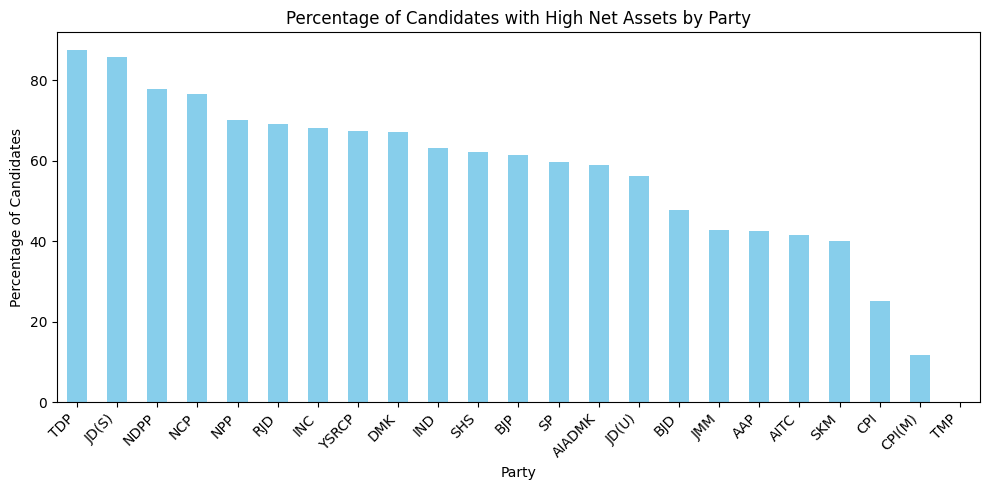

In [15]:
# Define the threshold for high net assets
high_net_assets_threshold = 10000000

# Calculate net assets for each candidate
train_df['Net Assets'] = train_df['Total Assets'] - train_df['Liabilities']

# Count the number of candidates with high net assets for each party
high_net_assets_cases = train_df[train_df['Net Assets'] > high_net_assets_threshold].groupby('Party').size()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate the percentage of candidates with high net assets for each party
percentage_high_net_assets = (high_net_assets_cases / party_candidate_count) * 100

plt.figure(figsize=(10, 5))
percentage_high_net_assets.rename(index={'Tipra Motha Party': 'TMP',
                                'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)
percentage_high_net_assets.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Percentage of Candidates with High Net Assets by Party')
plt.xlabel('Party')
plt.ylabel('Percentage of Candidates')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('poc_net_assets_vs_party.png')
plt.show()

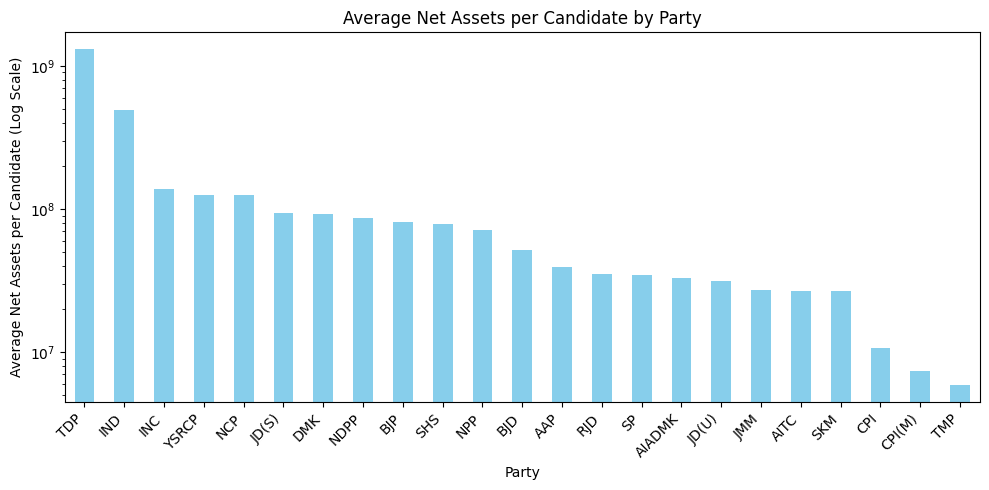

In [16]:
# Calculate net assets for each candidate
train_df['Net Assets'] = train_df['Total Assets'] - train_df['Liabilities']

# Group by party and calculate the total net assets
party_total_net_assets = train_df.groupby('Party')['Net Assets'].sum()

# Calculate the total number of candidates for each party
party_candidate_count = train_df['Party'].value_counts()

# Calculate average net assets per candidate for each party
avg_net_assets_per_candidate = party_total_net_assets / party_candidate_count

plt.figure(figsize=(10, 5))
avg_net_assets_per_candidate.rename(index={'Tipra Motha Party': 'TMP',
                                           'Sikkim Krantikari Morcha': 'SKM'}, inplace=True)
avg_net_assets_per_candidate.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title('Average Net Assets per Candidate by Party')
plt.xlabel('Party')
plt.ylabel('Average Net Assets per Candidate (Log Scale)')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.tight_layout()
plt.savefig('avg_net_assets_vs_party.png')
plt.show()

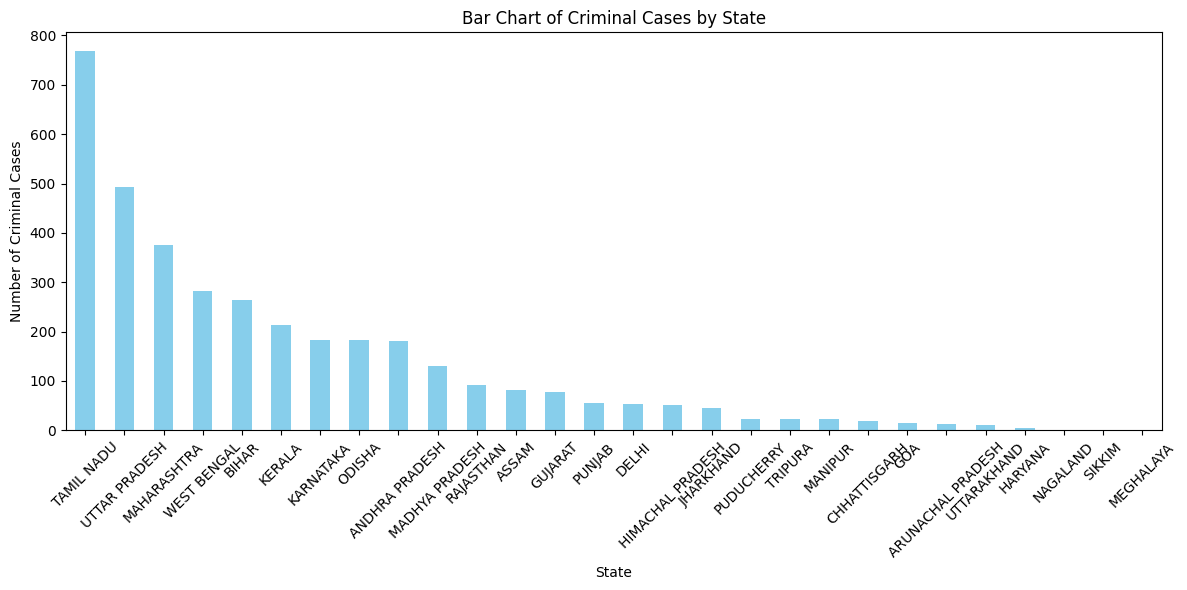

In [17]:
plt.figure(figsize=(12, 6))
criminal_cases_by_state = train_df.groupby('state')['Criminal Case'].sum()
criminal_cases_by_state.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Bar Chart of Criminal Cases by State')
plt.xlabel('State')
plt.ylabel('Number of Criminal Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('criminal_vs_state.png')
plt.show()

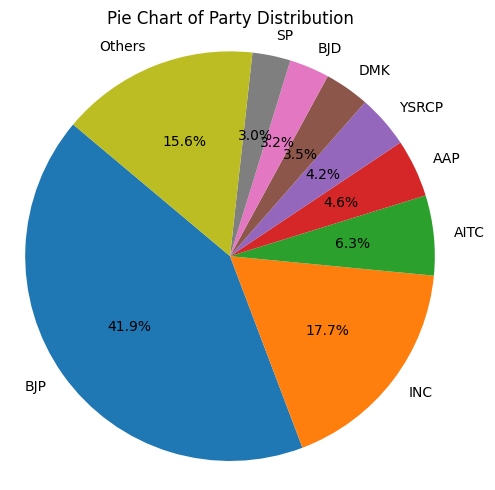

In [18]:
# Calculate party counts and percentages
party_counts = train_df['Party'].value_counts()
party_percentages = party_counts / party_counts.sum() * 100

# Set threshold percentage
threshold_percentage = 2.5 

# Combine parties with percentages less than the threshold into 'Others'
filtered_parties = party_percentages[party_percentages >= threshold_percentage]
filtered_parties['Others'] = party_percentages[party_percentages < threshold_percentage].sum()

plt.figure(figsize=(5, 5))
filtered_parties.plot(kind='pie', autopct='%1.1f%%', startangle=140)

plt.title('Pie Chart of Party Distribution')
plt.ylabel('')
plt.axis('equal')
plt.tight_layout()
plt.savefig('party_distribution.png')
plt.show()